In [1]:
!pip install transformers

In [0]:
import torch.utils.data as utils
import torch
import torch.nn as nn
import torch.optim as optim
from torch.hub import load
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.backends.backend_pdf import PdfPages
from fastai.text import *
from fastai.metrics import *
from functools import partial
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import AdamW
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from google.colab import drive

In [3]:
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig, 'bert-base-uncased'),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig, 'roberta-base')}

In [0]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""

    def __init__(self, pretrained_tokenizer: BertTokenizer, model_type='bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t: str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] + [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens


class TransformersVocab(Vocab):
    def __init__(self, tokenizer: BertTokenizer):
        super(TransformersVocab, self).__init__(itos=[])
        self.tokenizer = tokenizer

    def numericalize(self, t: Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        # return self.tokenizer.encode(t)

    def textify(self, nums: Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(
            self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(
            nums)

    def __getstate__(self):
        return {'itos': self.itos, 'tokenizer': self.tokenizer}

    def __setstate__(self, state: dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int, {v: k for k, v in enumerate(self.itos)})


class CustomTransformerModel(nn.Module):
    def __init__(self, CustomModel):
        super(CustomTransformerModel, self).__init__()
        self.transformer = CustomModel
        self.dropout = nn.Dropout(.05)
        self.classifier = nn.Linear(3, 3)

    def forward(self, input_ids):
        # Return only the logits from the transfomer
        logits = self.transformer(input_ids)[0]
        logits = self.classifier(logits)
        return logits

**Training and Evaluation**

In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/CleanTweets.csv'
dataset = pd.read_csv(path, engine='python')
dataset.reset_index(inplace=True, drop=True)
test_ratio = 0.3
train, test = train_test_split(dataset, test_size = test_ratio, shuffle=True)
#del(train['Index'])
#del(test['Index'])
NUM_EPOCHS = 3

**BERT**

In [25]:
key='bert'
model_class, tokenizer_class, config_class, model_name = MODEL_CLASSES[key]
transformer_tokenizer = tokenizer_class.from_pretrained(model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer=transformer_tokenizer,
                                                        model_type=key)

# set up tokenizer
fastai_tokenizer = Tokenizer(tok_func=transformer_base_tokenizer, pre_rules=[], post_rules=[])

transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer,
                                        include_bos=False,
                                        include_eos=False)
pad_first = bool(key in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

# initialize the rest
transformer_processor = [tokenize_processor, numericalize_processor]


databunch = (TextList.from_df(train, cols='Tweets', processor=transformer_processor)
              .split_by_rand_pct(0.1)
              .label_from_df(cols= 'Labels')
              .add_test(test)
              .databunch(bs=2, pad_first=pad_first, pad_idx=pad_idx))

config = config_class.from_pretrained(model_name)
config.num_labels = 3
transformer_model = model_class.from_pretrained(model_name, config = config)
custom_transformer_model = CustomTransformerModel(CustomModel = transformer_model)

CustomAdamW = partial(AdamW, correct_bias=False)
learner = Learner(databunch,
                  custom_transformer_model,
                  opt_func=CustomAdamW,
                  metrics=accuracy,
                  path='/content/gdrive/My Drive/Colab Notebooks/')
learner.unfreeze()
learner.freeze_to(-1)

In [26]:
learner.fit_one_cycle(NUM_EPOCHS, max_lr = 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,1.364212,1.119352,0.453073,21:58
1,0.871744,0.851185,0.453073,22:07
2,0.788982,0.842857,0.502760,22:19


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


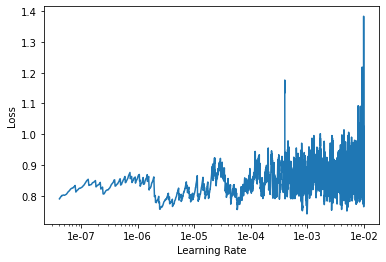

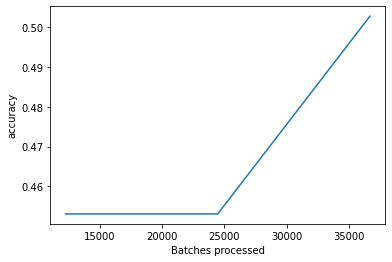

In [27]:
learner.recorder.plot()
learner.recorder.plot_metrics()

In [0]:
learner.save("bert_base_cleaned")

**ROBERTA**

In [29]:
key='roberta'
model_class, tokenizer_class, config_class, model_name = MODEL_CLASSES[key]
transformer_tokenizer = tokenizer_class.from_pretrained(model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer=transformer_tokenizer,
                                                        model_type=key)

# set up tokenizer
fastai_tokenizer = Tokenizer(tok_func=transformer_base_tokenizer, pre_rules=[], post_rules=[])

transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer,
                                        include_bos=False,
                                        include_eos=False)
pad_first = bool(key in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

# initialize the rest
transformer_processor = [tokenize_processor, numericalize_processor]


databunch = (TextList.from_df(train, cols='Tweets', processor=transformer_processor)
              .split_by_rand_pct(0.1)
              .label_from_df(cols= 'Labels')
              .add_test(test)
              .databunch(bs=2, pad_first=pad_first, pad_idx=pad_idx))

config = config_class.from_pretrained(model_name)
config.num_labels = 3
transformer_model = model_class.from_pretrained(model_name, config = config)
custom_transformer_model = CustomTransformerModel(CustomModel = transformer_model)

CustomAdamW = partial(AdamW, correct_bias=False)
learner = Learner(databunch,
                  custom_transformer_model,
                  opt_func=CustomAdamW,
                  metrics=accuracy,
                  path='/content/gdrive/My Drive/Colab Notebooks/')
learner.unfreeze()
learner.freeze_to(-1)

In [30]:
learner.fit_one_cycle(NUM_EPOCHS, max_lr = 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.860331,0.857580,0.503128,24:37
1,0.780506,0.877707,0.446816,24:50
2,0.882227,0.855804,0.503128,24:47


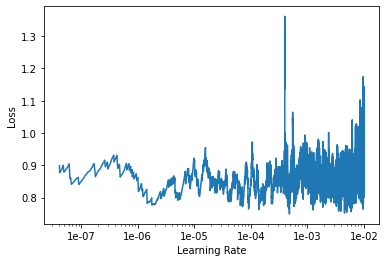

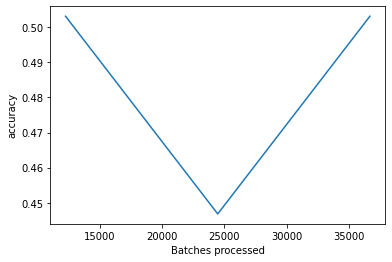

In [31]:
learner.recorder.plot()
learner.recorder.plot_metrics()

In [0]:
learner.save("roberta_base_cleaned")